In [8]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
import time

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

In [9]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

In [10]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(47)

batch_size = 1
n_samples = 6400  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

idx = torch.where((X_train.targets >= 0) & (X_train.targets <= 7))[0][1000:n_samples+1000]
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

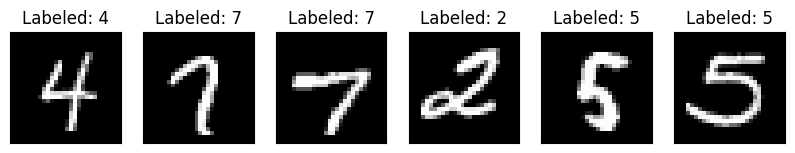

In [11]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [12]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 100

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

idx = torch.where((X_test.targets >= 0) & (X_test.targets <= 7))[0][:n_samples]
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

In [13]:
# Define torch NN module
device = torch.device("cuda")

class Net(Module):
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 8)  # 3-dimensional input to QNN
        self.fc3 = Linear(8, 8)
        self.fc3 = Linear(8, 8)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

model4 = Net().to(device)

In [14]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

start_time = time.time()

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

end_time = time.time()

print('time taken: ', end_time - start_time)

Training [10%]	Loss: 0.5322
Training [20%]	Loss: 0.2243
Training [30%]	Loss: 0.1695
Training [40%]	Loss: 0.1502
Training [50%]	Loss: 0.1317
Training [60%]	Loss: 0.1257
Training [70%]	Loss: 0.1085
Training [80%]	Loss: 0.1052
Training [90%]	Loss: 0.0974
Training [100%]	Loss: 0.0936
time taken:  119.59447264671326


In [15]:
torch.save(model4.state_dict(), "model4.pt")

In [16]:
model5 = Net()
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [17]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: 0.0929
	Accuracy: 99.0%
